In [43]:
import math

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)

        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self, other):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supprting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        def _back():
            self.grad += other * (self.data**(other-1)) * out.grad

        out._backward = _back
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad +=  (1-out.data**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        
        out = Value(math.exp(x), (self,), 'exp')

        def _back():
            self.grad += out.data * out.grad
            
        out._backward = _back

        return out


In [44]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [45]:
import random

class Neuron:
    """nin: number of inputs"""
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    """Forward pass"""
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in (zip(self.w, x))), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    """nout: number of neurons?"""
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    """nouts: list of nout"""
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params

    def zero_grad(self):
        for p in n.parameters():
            p.grad = 0

In [477]:
# Setup the Neural Network

n = MLP(3, [4, 4, 1])
total_passes = 0

In [478]:
# Inputs

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0,5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets


# Setup prediction and loss
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

loss.data

5.531329475532363

In [490]:
# Fitting the neural net
# Run this several times to train the neural net
# The goal is to decrease loss

for k in range(20):
    ypred = [n(x) for x in xs]
    
    # Mean squared error for loss function
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    n.zero_grad()
    
    loss.backward()

    # here you would decrease the learning rate over time
    for p in n.parameters():
        p.data += -0.1* p.grad
    print(k, loss.data)
    total_passes+=1

print(f"Predictions after {total_passes} passes")
print("-----")
for i, pred in enumerate(ypred):
    print(f"Current prediction: {pred.data}")
    print(f"Desired prediction: {ys[i]}")
    print("-----")

0 0.003464755955144886
1 0.003442854928360248
2 0.003421216915316435
3 0.003399837283561218
4 0.0033787115078859464
5 0.0033578351672556997
6 0.0033372039418439335
7 0.003316813610167531
8 0.0032966600463182837
9 0.0032767392172869327
10 0.00325704718037652
11 0.0032375800807012576
12 0.0032183341487677804
13 0.003199305698135717
14 0.0031804911231543597
15 0.003161886896772855
16 0.0031434895684208626
17 0.0031252957619572856
18 0.003107302173684304
19 0.003089505570424687
Predictions after 200 passes
-----
Current prediction: 0.9749431990387727
Desired prediction: 1.0
-----
Current prediction: -0.9612866173964036
Desired prediction: -1.0
-----
Current prediction: -0.9901315927264221
Desired prediction: -1.0
-----
Current prediction: 0.9705797545679088
Desired prediction: 1.0
-----


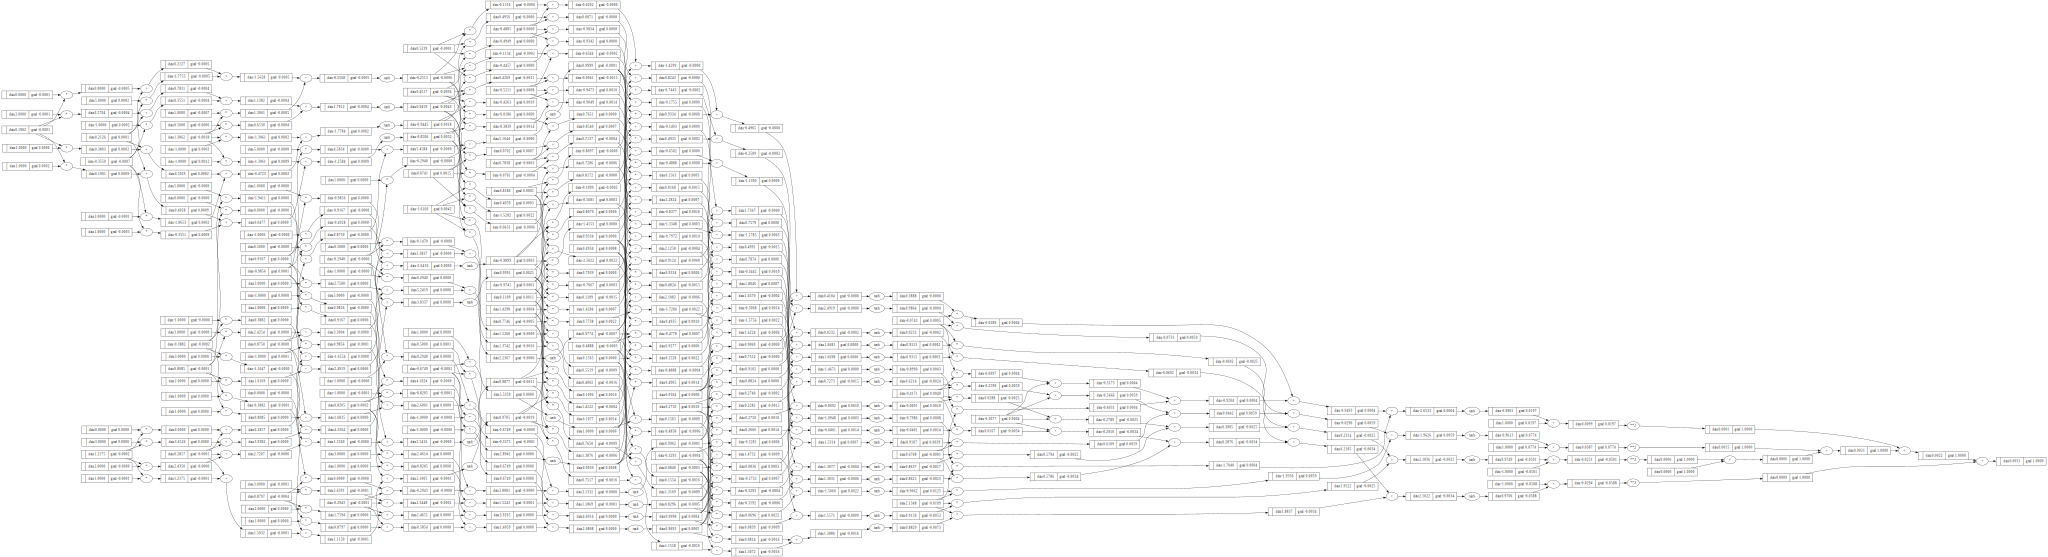

In [491]:
draw_dot(loss)